## 迷宮遊戲：以狀態值函數大者為行動依據

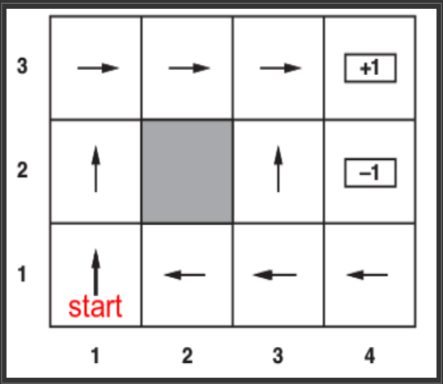

In [23]:
from IPython.display import Image
Image('./images/maze.png', width=300)

### 起點為(1, 1)，終點為(4, 3)或(4, 2)，走到(4, 3)獎勵為1，走到(4, 2)獎勵為 -1，每走一步獎勵均為 -0.04。

In [24]:
# 載入相關套件
import numpy as np
import random

In [25]:
# 參數設定
ROW_COUNT, COLUMN_COUNT = 3, 4         # 3列 x 4行
NODE_COUNT = ROW_COUNT * COLUMN_COUNT  # 節點總數
NORMAL_REWARD = -0.04 # 每走一步扣分 -0.04
WIN_REWARD = 1    # 終點(4, 3)的得分
LOSS_REWARD = -1  # 終點(4, 2)的失分

# 特殊節點
WIN_TERMINAL = NODE_COUNT-1    # 得分的終點
LOSS_TERMINAL = NODE_COUNT-1-COLUMN_COUNT # 失分的終點
WALL_NODES = [5]                # 牆節點，不能駐留的節點
# 行動空間
(UP, DOWN, LEFT, RIGHT) = range(4) # 上/下/左/右

In [26]:
x = [0, 4, 0, 1, 2, 1, 0, 4, 0, 1, 2, 1, 2, 3, 7]
set(x)

{0, 1, 2, 3, 4, 7}

In [27]:
x = [0, 4, 0, 1, 2, 1, 0, 4, 0, 1, 2, 1, 2, 3, 7]
x.reverse() 
x

[7, 3, 2, 1, 2, 1, 0, 4, 0, 1, 2, 1, 0, 4, 0]

In [28]:
# 環境類別
class Environment():
    # 初始化
    def __init__(self):
        # 儲存狀態值函數
        self.state_value = np.full(NODE_COUNT, 0.0)

        # 更新次數
        self.state_value_count = np.full(NODE_COUNT, 0)
        
    # 初始化
    def reset(self):
        self.poistion = 0  # 玩家開始的位置
        self.trajectory=[self.poistion] # 行動軌跡

    def get_states(self):
        # 狀態空間(State Space)
        return [i for i in range(NODE_COUNT)]

    def get_actions(self):  
        # 行動空間(Action Space)
        return [UP, DOWN, LEFT, RIGHT] # 上/下/左/右

    def is_done(self): # 判斷比賽回合是否結束
        # 是否走到終點
        return self.poistion == WIN_TERMINAL or self.poistion == LOSS_TERMINAL
    
    # 更新位置
    def update_poistion(self, action):
        if action == DOWN:
            new_poistion = self.poistion - COLUMN_COUNT
        if action == UP:
            new_poistion = self.poistion + COLUMN_COUNT
        if action == LEFT:
            new_poistion = self.poistion - 1
        if action == RIGHT:
            new_poistion = self.poistion + 1
            
        if new_poistion < 0 or new_poistion > NODE_COUNT \
            or new_poistion in WALL_NODES: 
            return self.poistion
        
        return new_poistion
    
    # 步驟
    def step(self, action):
        # 是否回合已結束
        if self.is_done():
            raise Exception("Game over")
            
        self.poistion = self.update_poistion(action)
        self.trajectory.append(self.poistion)        
        if self.poistion == WIN_TERMINAL:
            reward = WIN_REWARD
        elif self.poistion == LOSS_TERMINAL:
            reward = LOSS_REWARD
        else:    
            reward = NORMAL_REWARD

        return self.poistion, reward

    def update_state_value(self, final_value):
        # 考慮節點被走過兩次或以上，分數會被重複扣分
        # 採首次訪問(first visit)的報酬更新狀態值 
        distinct_node_list = list(set(self.trajectory))
        # print('distinct_node_list:', distinct_node_list)
        distinct_state_value = np.full(len(distinct_node_list), 0.0)
        # 倒推，更新狀態值函數
        reverse_trajectory = self.trajectory.copy()
        reverse_trajectory.reverse()  
        for i in reverse_trajectory:
            final_value += NORMAL_REWARD
            # 如有訪問多次的節點，狀態值會被蓋掉
            index = distinct_node_list.index(i) # 取得索引值
            distinct_state_value[index] = final_value # 暫存狀態值函數
            
        # 更新軌跡的狀態值函數
        # print('distinct_state_value:', distinct_state_value)
        for index, val in enumerate(distinct_node_list):
            # 更新狀態值函數
            self.state_value[val] += distinct_state_value[index] 
            self.state_value_count[val] += 1        
                
    # 取得狀態值函數期望值
    def get_observation(self):
        mean1 = np.full(NODE_COUNT, 0.0)
        for i in range(NODE_COUNT):
            if self.state_value_count[i] == 0: 
                mean1[i] = 0
            else:
                mean1[i] = self.state_value[i] / self.state_value_count[i]
        return mean1

In [29]:
# 代理人類別
class Agent():
    # 初始化
    def __init__(self):
        pass
        
    # 取得可以行走的方向
    def check_possible_action(self, env):
        possible_actions = env.get_actions()
        if env.poistion < COLUMN_COUNT: # 最下一列不可向下
            possible_actions.remove(DOWN)
        if env.poistion % COLUMN_COUNT == 0: # 第一行不可向左
            possible_actions.remove(LEFT)
        if env.poistion >= NODE_COUNT - COLUMN_COUNT : # 最上一列不可向上
            possible_actions.remove(UP)
        if env.poistion % COLUMN_COUNT == COLUMN_COUNT -1 : # 最右一行不可向右
            possible_actions.remove(RIGHT)
            
        if env.poistion -1 in WALL_NODES : # 向左若遇牆，不可向左
            possible_actions.remove(LEFT)
        if env.poistion +1 in WALL_NODES : # 向右若遇牆，不可向右
            possible_actions.remove(RIGHT)
        if env.poistion + COLUMN_COUNT in WALL_NODES : # 向上若遇牆，不可向上
            possible_actions.remove(UP)
        if env.poistion - COLUMN_COUNT in WALL_NODES : # 向下若遇牆，不可向下
            possible_actions.remove(DOWN)
            
        return possible_actions
        
    def action(self, env):
        # 取得狀態值函數期望值
        state_value = env.get_observation()

        # 找到最大的狀態值函數
        max_value = -999
        next_action_list = [] 
        possible_actions = self.check_possible_action(env)
        # print('possible_actions:', possible_actions)
        for i in possible_actions:
            if state_value[env.update_poistion(i)] > max_value:
                max_value = state_value[env.update_poistion(i)]
                next_action_list = [i]
            elif state_value[env.update_poistion(i)] == max_value:
                next_action_list += [i]
            # print('next_action:', next_action_list, ', max_value:', max_value)
                
        if len(next_action_list) == 0:
            next_action = random.choice(possible_actions) 
        else: # 有多個最大狀態值函數的節點，隨機抽樣
            next_action = random.choice(next_action_list)
            new_poistion = env.update_poistion(next_action)
            
        # 若發生循環，隨機抽樣
        while len(possible_actions) > 1 and len(env.trajectory)>=4 and \
            new_poistion == env.trajectory[-2] and \
            new_poistion == env.trajectory[-4] :
            # print('loop:', env.trajectory[-4:], new_poistion)
            possible_actions.remove(next_action)          # 去除造成循環的行動
            next_action = random.choice(possible_actions) # 選擇其他的行動
            new_poistion = env.update_poistion(next_action)
            # print('change action:', new_poistion)
            
        # print('next_action:', next_action_list, ', max_value:', max_value)
        return next_action           

In [30]:
# 建立實驗，含環境、代理人物件
env = Environment()
agent = Agent()

# 進行實驗
total_reward_list = []
no = 0
done_no = 0
while no < 100 and done_no < 41:
    no += 1
    env.reset()  # 重置
    total_reward=0  # 累計報酬
    action_count = 0
    while not env.is_done():
        # 採取行動
        action = agent.action(env)
        action_count+=1
        
        # 更新下一步
        state, reward = env.step(action)
        #print(state, reward)
        # 計算累計報酬
        total_reward += reward
        
        # 避免一直循環，跑不完
        if action_count > 100:
            env.poistion = 0
            break
    
    print('trajectory', done_no, ':', env.trajectory)
    # 未達終點不更新值函數，以免過度降低循環節點的值函數
    if action_count <= 100:
        env.update_state_value(total_reward)
        total_reward_list.append(round(total_reward, 2))
        done_no += 1
        
    # state_value = np.around(env.get_observation().reshape(ROW_COUNT, COLUMN_COUNT),2)
    # print(f"state value:\n{np.flip(state_value, axis=0)}") # 列反轉，與圖一致，便於觀察
    total_reward_list.append(round(total_reward, 2))
    
# 顯示累計報酬
print(f"累計報酬: {total_reward_list}")

trajectory 0 : [0, 4, 8, 9, 8, 9, 10, 6, 7]
trajectory 1 : [0, 1, 2, 3, 2, 1, 0, 1, 2, 3, 2, 1, 0, 1, 2, 3, 2, 1, 0, 1, 2, 3, 2, 1, 0, 1, 2, 3, 2, 3, 7]
trajectory 2 : [0, 4, 8, 9, 10, 11]
trajectory 3 : [0, 4, 8, 9, 10, 11]
trajectory 4 : [0, 4, 8, 9, 10, 11]
trajectory 5 : [0, 4, 8, 9, 10, 11]
trajectory 6 : [0, 4, 8, 9, 10, 11]
trajectory 7 : [0, 4, 8, 9, 10, 11]
trajectory 8 : [0, 4, 8, 9, 10, 11]
trajectory 9 : [0, 4, 8, 9, 10, 11]
trajectory 10 : [0, 4, 8, 9, 10, 11]
trajectory 11 : [0, 4, 8, 9, 10, 11]
trajectory 12 : [0, 4, 8, 9, 10, 11]
trajectory 13 : [0, 4, 8, 9, 10, 11]
trajectory 14 : [0, 4, 8, 9, 10, 11]
trajectory 15 : [0, 4, 8, 9, 10, 11]
trajectory 16 : [0, 4, 8, 9, 10, 11]
trajectory 17 : [0, 4, 8, 9, 10, 11]
trajectory 18 : [0, 4, 8, 9, 10, 11]
trajectory 19 : [0, 4, 8, 9, 10, 11]
trajectory 20 : [0, 4, 8, 9, 10, 11]
trajectory 21 : [0, 4, 8, 9, 10, 11]
trajectory 22 : [0, 4, 8, 9, 10, 11]
trajectory 23 : [0, 4, 8, 9, 10, 11]
trajectory 24 : [0, 4, 8, 9, 10, 11]
traj

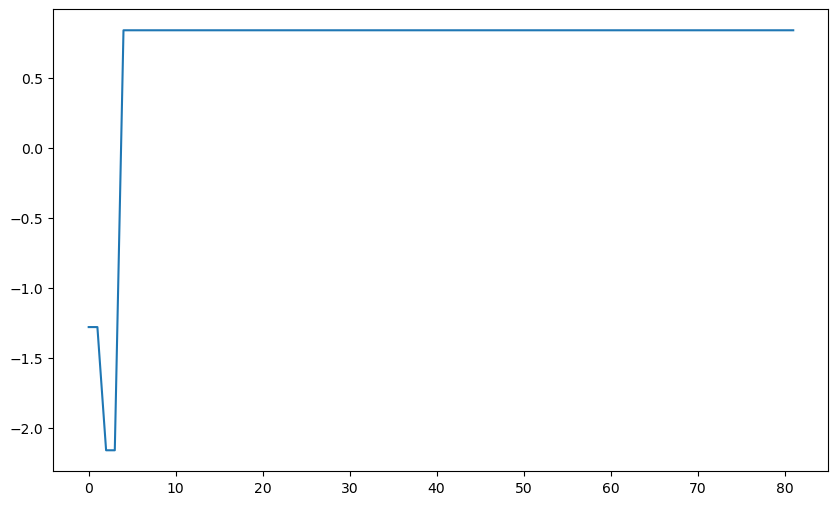

In [31]:
# 繪圖
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(total_reward_list)

In [32]:
# 觀察最後的狀態期望值
env.get_observation().reshape(3,4)

array([[ 0.44780488, -3.36      , -3.32      , -3.28      ],
       [ 0.584     ,  0.        , -1.36      , -1.76      ],
       [ 0.624     ,  0.664     ,  0.706     ,  0.8       ]])